<a href="https://colab.research.google.com/github/DanielOsorio1/Final-Project/blob/main/Final_Project_BME3053C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BME3053C Proposal

Topic: Our goal is to create a model to detect and count cells in microscopy images, aiding in quantitative biological research. The model should be able to count a variety of types of cells when stained, e.g., flatter fibroblasts vs. rounder red blood cells. The GitHub linked below is the Automatic Cell Counting with Trainable Weka Segmentation (TWS), which provides a machine-learning basis for an accessible and automatic cell counting technology. 19,200 images of cells with stained nuclei in the BBBC database will be used in an 80-20 train-test split for our model. The second link is a model which requires only one picture for training, which would be useful in the case of limited training images but can offer a good comparison on the accuracy between both models.

Model(s): https://github.com/tkataras/Automatic-Cell-counting-with-TWS.git

https://pmc.ncbi.nlm.nih.gov/articles/PMC9849527/

Dataset(s): https://bbbc.broadinstitute.org/BBBC005

The BBBC005v1 dataset from the Broad Bioimage Benchmark Collection contains images of DAPI-stained nuclei, suitable for training cell detection models.


In [ ]:
# Mount Images from Google Drive to Content
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###############################################################################################

### Final BME3053C Project: Detecting and Counting Cells Using ML Model ###

###############################################################################################
# Import Necessary Libraries
import os
import cv2
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split

# Step 2: Set the ground truth directory path
# Replace "My Drive/Path_to_Dataset" with the actual path in your Google Drive
ground_truth_dir = "/content/drive/MyDrive/TrainingImages/BBBC005_v1_ground_truth"

# Step 3: Function to load ground truth images
def load_ground_truth_images(ground_truth_dir):
    images = []
    labels = []

    for file in os.listdir(ground_truth_dir):
        if file.endswith('.TIF'):
            filepath = os.path.join(ground_truth_dir, file)

            # Load the ground truth image
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

            # Extract cell count from filename
            # Example filename: SIMCEPImages_well_C10_Fblur_ssamples_wstain.TIF
            parts = file.split('_')
            cell_count = int(parts[2][1:])  # Extract the cell count part

            images.append(image)
            labels.append(cell_count)

    return np.array(images), np.array(labels)

# Step 4: Load images and labels from the ground truth directory
images, labels = load_ground_truth_images(ground_truth_dir)

# Step 5: Perform an 80-20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize images for model input
X_train = X_train / 255.0
X_test = X_test / 255.0

# Add a channel dimension for compatibility with CNNs
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 960
Testing set size: 240


**Purpose (Libraries)**: Imports essential libraries:

*   **os and cv2**: For file handling and image processing.
*   **numpy**: For numerical operations.


*   **train_test_split**: Splits data into training and testing sets.
*   **google.colab.drive**: Accesses datasets stored on Google Drive.


**Purpose (load_ground_test_truth)**: Reads ground truth images and extracts their corresponding cell counts from filenames. Returns image-label pairs as arrays.

**Purpose (test/train)**: Splits the dataset into 80% training and 20% testing sets.

*   Normalizes images to improve model
convergence and reshapes them to include a channel dimension for CNN compatibility.








X_train shape: (960, 520, 696, 1)
y_train shape: (960,)


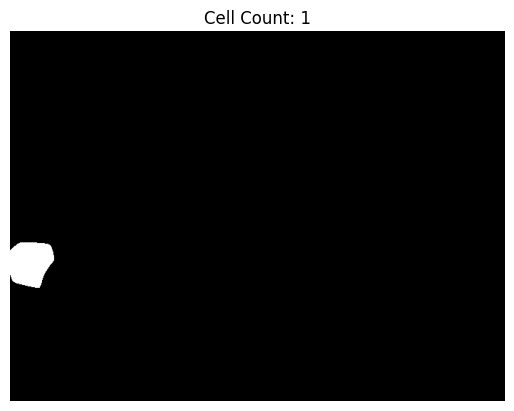

In [ ]:
import matplotlib.pyplot as plt

# Verify the shape of the dataset
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Display one of the training images
def display_sample_image(images, labels, index=0):
    if index < len(images):
        image = images[index].squeeze()  # Remove extra dimensions for visualization
        label = labels[index]

        # Plot the image
        plt.imshow(image, cmap='gray')
        plt.title(f"Cell Count: {label}")
        plt.axis('off')
        plt.show()
    else:
        print("Index out of range!")

# Display the first training image
display_sample_image(X_train, y_train, index=0)


**Purpose**:


*   Displays a single training image and its label (cell count) for dataset verification.
*   Display X_train set shape and y_train set shape



In [ ]:
# Import Necessary Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
def create_model(input_shape):
    """
    Creates a CNN model for cell count prediction.

    Args:
    - input_shape: Tuple defining the input dimensions (height, width, channels).

    Returns:
    - A compiled CNN model.
    """
    model = Sequential([
        # Convolutional Layers
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten Layer
        Flatten(),

        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  # Regression output for cell count
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

# Define the model
input_shape = X_train[0].shape  # Example shape: (128, 128, 1)
model = create_model(input_shape)

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 518, 694, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 259, 347, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 257, 345, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 128, 172, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 170, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 85, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 685440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      87,736,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,829,249 (335.04 MB)

 Trainable params: 87,829,249 (335.04 MB)

 Non-trainable params: 0 (0.00 B)

The goal of the CNN is to:

**Extract Features**: Identify patterns or features (e.g., shapes, edges) that help determine the number of cells in an image.

**Perform Regression**: Use these features to output a continuous value representing the predicted cell count for the image.

**Input Layer**
*  **Purpose**: Defines the shape of the
input images. Here, the images are grayscale (1 channel) with a fixed height and width.
*  **Reasoning**: The CNN processes 2D pixel data and learns spatial relationships.

**Convolutional Layer**
*   **Purpose**: These layers apply filters (small sliding windows) to the image to extract features such as edges, corners, or textures.

**Pooling Layers**
*   **Purpose**: Reduces the spatial dimensions of the feature maps, retaining the most important information while reducing computational complexity.
*     **Reasoning:** Prevents overfitting by simplifying the data. It makes the model robust to small shifts or distortions in the image.

**Flatten Layer**
*   **Purpose**: Transforms the 2D feature maps (from convolution and pooling layers) into a 1D vector.
*   **Reasoning**: This vector representation is fed into the dense layers for prediction.

**Fully Connected (Dense) Layers**
*   **Purpose**:
The first dense layer learns high-level representations of the image features.The final dense layer outputs a single continuous value representing the cell count.

**Dropout Layer**
*   **Purpose:** Prevents overfitting by randomly "dropping out" 50% of the neurons during training.
*   **Reasoning:** Ensures the model doesn't rely too heavily on specific neurons and generalizes better to unseen data.

**Loss Function**
*   **Purpose**: Measures the average squared difference between predicted and actual cell counts.
*   **Reasoning**: In regression tasks, minimizing MSE leads to predictions that are closer to the ground truth.

**Optimizer**
*  **Purpose**: Updates the weights of the CNN during training to minimize the loss function.
*   **Adam Optimizer**:
Combines the benefits of two other optimizers, AdaGrad and RMSProp, for efficient and effective training.

**Metrics**
*   **Purpose**: Tracks the mean absolute error (MAE) during training, providing an interpretable measure of prediction accuracy.










In [ ]:
# Train the model # 80% of Images
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of training data as validation
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 675ms/step - loss: 457.0710 - mean_absolute_error: 16.4150 - val_loss: 107.6534 - val_mean_absolute_error: 8.3308
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - loss: 168.0394 - mean_absolute_error: 9.9056 - val_loss: 86.1341 - val_mean_absolute_error: 7.0776
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - loss: 145.0486 - mean_absolute_error: 8.7784 - val_loss: 97.1389 - val_mean_absolute_error: 7.8005
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 126.0212 - mean_absolute_error: 8.3431 - val_loss: 152.8581 - val_mean_absolute_error: 9.6044
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - loss: 136.5625 - mean_absolute_error: 8.0503 - val_loss: 111.4379 - val_mean_absolute_error: 8.1529
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - loss: 106.9526 - mean_absolute_error: 7.4722 - val_loss: 102.4895 - val_mean_absolute_error: 7.8950
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - loss: 110.3229 - mea

In [ ]:
# Evaluate on test set # 20% of Images
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 899ms/step - loss: 140.3427 - mean_absolute_error: 9.4481
Test Loss: 141.26954650878906
Test Mean Absolute Error: 9.518688201904297


**Purpose**: Evaluates the model on the test set and prints the loss and mean absolute error (MAE). Trains the model using 80% of the training set for training and 20% for validation over 20 epochs.





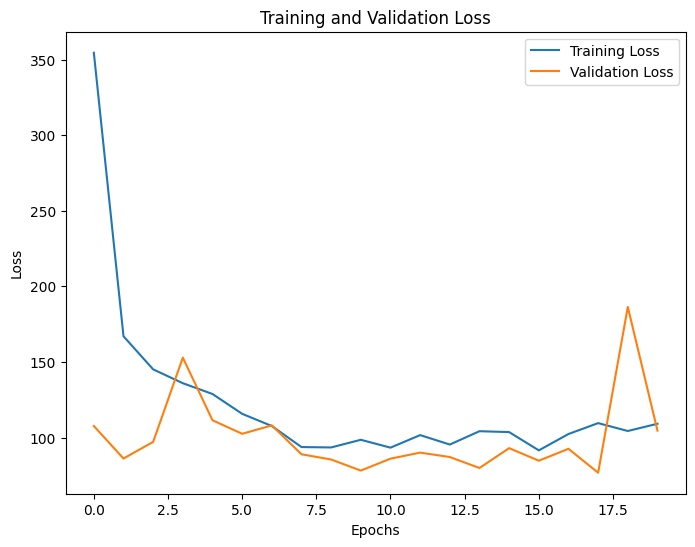

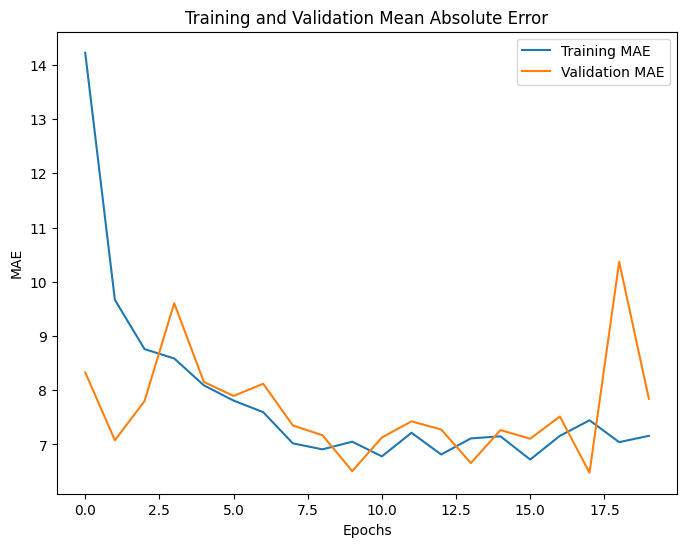

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot mean absolute error
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [ ]:
# Predict on a sample from the test set
sample_image = X_test[0]
sample_label = y_test[0]

# Add batch dimension for prediction
sample_image = np.expand_dims(sample_image, axis=0)

predicted_count = model.predict(sample_image)[0][0]
print(f"True Cell Count: {sample_label}")
print(f"Predicted Cell Count: {predicted_count}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True Cell Count: 48
Predicted Cell Count: 39.54701614379883


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


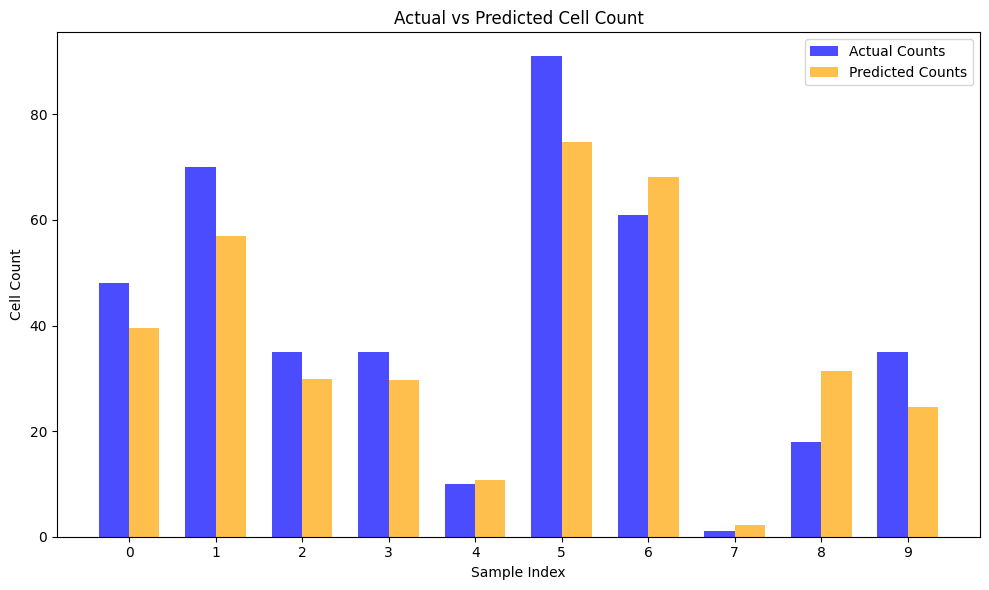

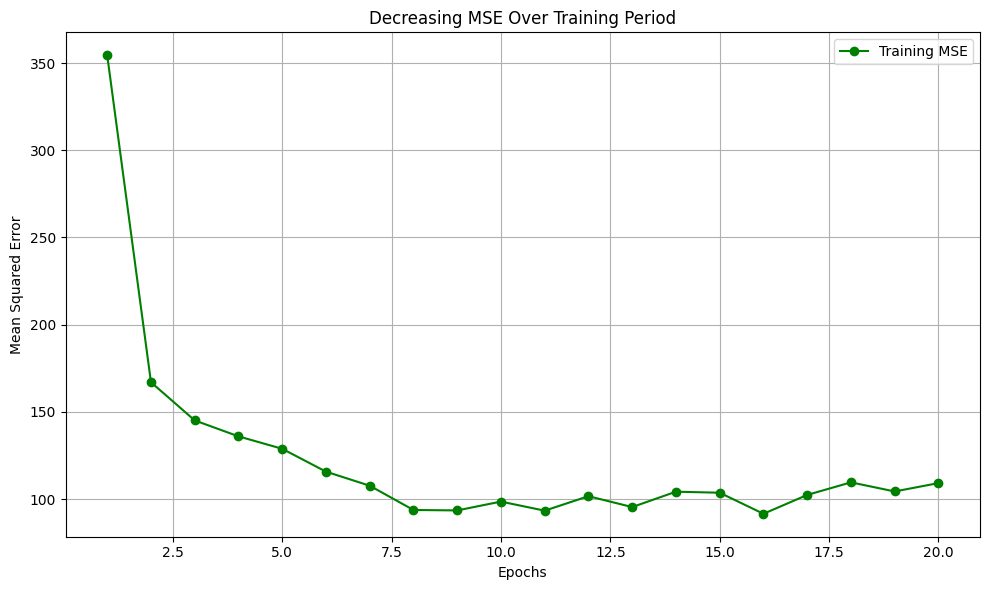

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with actual predictions and ground truth data from the model
true_counts = y_test[:10]  # First 10 samples from the test set for visualization
predicted_counts = model.predict(X_test[:10]).flatten()  # Predicted values for the same samples

# Plot actual vs predicted counts as a bar graph
def plot_actual_vs_predicted(true_counts, predicted_counts):
    indices = np.arange(len(true_counts))
    width = 0.35  # Width of the bars

    plt.figure(figsize=(10, 6))
    plt.bar(indices - width/2, true_counts, width, label='Actual Counts', alpha=0.7, color='blue')
    plt.bar(indices + width/2, predicted_counts, width, label='Predicted Counts', alpha=0.7, color='orange')
    plt.xlabel('Sample Index')
    plt.ylabel('Cell Count')
    plt.title('Actual vs Predicted Cell Count')
    plt.xticks(indices)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(true_counts, predicted_counts)

# Plot MSE over training epochs using history
def plot_mse_over_epochs(history):
    epochs = range(1, len(history.history['loss']) + 1)
    mse_values = history.history['loss']  # Training MSE over epochs

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mse_values, label='Training MSE', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Decreasing MSE Over Training Period')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mse_over_epochs(history)


**Purpose**:
*   Compares actual cell counts and predicted values as a bar graph.
*   Plots the mean squared error (MSE) across epochs to visualize model improvement during training.
